## Data Prep

**Import necessary modules and the ASOS/SNOTEL dataframes**

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dtb
import os
from glob import glob
import datetime as dt
import seaborn as sns

In [3]:
data = [pd.read_csv('asos_snotel_UA_df.dat', parse_dates = True, index_col = 'Date_Time')]
asos_snotel_UA_df = pd.concat(data)
asos_snotel_UA_df['LXV_WindSpeed_m/s']

asos_snotel_UA_df.rename(columns={'LXV_WindSpeed_m/s': 'LXV_WindSpeed_mps'}, inplace=True)

asos_snotel_UA_df.astype('float16')
pd.set_option('display.expand_frame_repr', True)


print(asos_snotel_UA_df.keys())




#delete empty columns as they mess up loops
#del asos_snotel_UA_df['CMtn_6hr_Precipitation_mm']            #empty column


Index(['CMtnSNTL_Temp_degC', 'CMtnSNTL_SnowDepth_in', 'CMtn_Temperature_degC',
       'CMtn_Dewpoint_degC', 'CMtn_WindDirection_deg', 'CMtn_WindSpeed_mps',
       'CMtn_CloudCover_oktas', 'CMtn_1hr_Precipitation_mm',
       'LXV_Temperature_degC', 'LXV_Dewpoint_degC',
       ...
       'KGJT_d300_200_height_m', 'KGJT_d300_200_tmpc', 'KGJT_d300_200_dwpc',
       'KGJT_d300_200_drct', 'KGJT_d300_200_speed_kts',
       'KGJT_d250_200_height_m', 'KGJT_d250_200_tmpc', 'KGJT_d250_200_dwpc',
       'KGJT_d250_200_drct', 'KGJT_d250_200_speed_kts'],
      dtype='object', length=156)


### Create 12 hr snowfall dataframe by using 12hr snowdepth difference

count    306.000000
mean       4.640098
std        2.189155
min        3.000000
25%        3.000000
50%        4.000000
75%        5.000000
max       16.000000
Name: CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in, dtype: float64


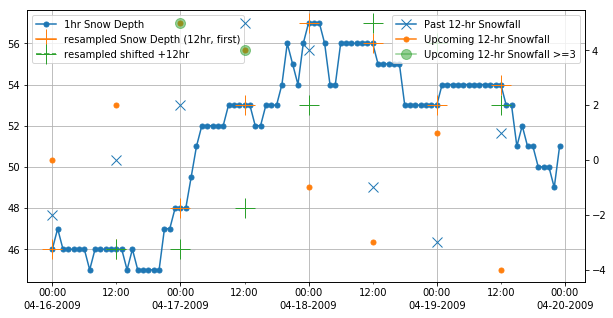

In [4]:
import matplotlib.dates as mdates
#fig = plt.figure(figsize=(10,5))
fig, ax1 = plt.subplots(figsize=(10,5))

#Calculate 12-snowfall column by finding difference between 12-hr snow depth observations 
asos_snotel_UA_df['CMtnSNTL_12hr_SNWD_in'] = asos_snotel_UA_df['CMtnSNTL_SnowDepth_in'].resample('12H').first()
asos_snotel_UA_df['CMtnSNTL_12hr-dSNWD_in'] = asos_snotel_UA_df['CMtnSNTL_12hr_SNWD_in']-asos_snotel_UA_df['CMtnSNTL_12hr_SNWD_in'].shift(+12)
asos_snotel_UA_df['CMtnSNTL_Past12hrSNOWFALL_in'] = asos_snotel_UA_df['CMtnSNTL_12hr-dSNWD_in']
asos_snotel_UA_df['CMtnSNTL_Upcoming12hrSNOWFALL_in'] = asos_snotel_UA_df['CMtnSNTL_12hr-dSNWD_in'].shift(-12)


asos_snotel_UA_df['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in'] = asos_snotel_UA_df['CMtnSNTL_Upcoming12hrSNOWFALL_in'][asos_snotel_UA_df['CMtnSNTL_Upcoming12hrSNOWFALL_in']>=3]
asos_snotel_UA_df['CMtnSNTL_Past12hrSNOWFALL_gte3_in'] = asos_snotel_UA_df['CMtnSNTL_Past12hrSNOWFALL_in'][asos_snotel_UA_df['CMtnSNTL_Past12hrSNOWFALL_in']>=3]

shifted_df = pd.DataFrame()
shifted_df = asos_snotel_UA_df['CMtnSNTL_12hr_SNWD_in'].shift(+12).copy()

#fig = plt.figure(figsize=(30,15))
#plt.subplot(2,1, 1)
#plt.subplots_adjust(hspace=0.5, wspace=0.2)


ax2 = ax1.twinx()
ax1.plot(asos_snotel_UA_df['CMtnSNTL_SnowDepth_in']['04-16-2009':'04-19-2009'], marker='.', markersize = 10, label = "1hr Snow Depth")

ax1.plot(asos_snotel_UA_df['CMtnSNTL_12hr_SNWD_in']['04-16-2009':'04-19-2009'], marker='+', markersize = 20, label = "resampled Snow Depth (12hr, first)")
ax1.plot(asos_snotel_UA_df['CMtnSNTL_12hr_SNWD_in']['04-16-2009':'04-19-2009'].shift(+12), marker='+',linestyle='--', markersize = 20, label = "resampled shifted +12hr")
ax2.plot(asos_snotel_UA_df['CMtnSNTL_Past12hrSNOWFALL_in']['04-16-2009':'04-19-2009'], marker='x', markersize = 10,  label = "Past 12-hr Snowfall")
ax2.plot(asos_snotel_UA_df['CMtnSNTL_Upcoming12hrSNOWFALL_in']['04-16-2009':'04-19-2009'], marker='.', markersize = 10,  label = "Upcoming 12-hr Snowfall")
ax2.plot(asos_snotel_UA_df['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in']['04-16-2009':'04-19-2009'], marker='.', markersize = 20, alpha = 0.5,  label = "Upcoming 12-hr Snowfall >=3")

#ax2 = asos_snotel_UA_df['CMtn_1hr_Precipitation_mm']['01-06-2009':'01-09-2009'].plot(marker='+', markersize = 10, secondary_y = True)

ax1.xaxis.set_major_locator(mdates.DayLocator(interval=1))
ax1.xaxis.set_minor_locator(mdates.HourLocator(byhour=range(0, 24, 12)))
ax1.xaxis.set_minor_formatter(mdates.DateFormatter('%H:%M'))  # hours and minutes
ax1.xaxis.set_major_formatter(mdates.DateFormatter('\n%m-%d-%Y')) 
#ax00.set_xlim(100, 12)

#plt.plot(shifted_df, linestyle = '-', linewidth = 10)
#print(shifted_df.describe)

#xlabel('Item (s)')
#ylabel('Value')
#title('Python Line Chart: Plotting numbers')

#plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)
ax1.grid(True)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')



#print(asos_snotel_df['12hr-dSNWD_in'].describe())
print(asos_snotel_UA_df['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in'].describe())


It is important to keep in mind that 'CMtnSNTL_12hr_SNWD_in contains snow depth info taken at the start of the respective 12hr period timestamp.  The snowfall calculated also gives the snowfall that fell in the 12hrs after the timestamp.  The OLS model will utilize hourly meteorological measurements at exactly 00:00 and 12:00 hours to predict the amount of snow which will fall in the next 12 hour period.  For example, the 00:00 meteorological measurements will be used to predict the snow which fell between 00:00 and 12:00.

In [ ]:
        import re
        from scipy.stats import pearsonr, linregress
        snf_df = asos_snotel_UA_df['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in']    
        xx_df = asos_snotel_UA_df['CMtn_Dewpoint_degC']  #.resample('12H').mean()
        idx = np.isfinite(xx_df) & np.isfinite(snf_df)
        
        sns.regplot(xx_df[idx], snf_df[idx])
    
        pearson, pv = pearsonr(xx_df[idx], snf_df[idx])
        slope, intercept, r_value, p_value, std_err = linregress(xx_df[idx], snf_df[idx])
        
    

        plt.annotate(' slope: ' + str(round(slope,3)) +
                 '\n intercept: ' + str(round(intercept,3)) + 
                 '\n R value: ' + str(round(r_value,3)) +  
                 '\n p value: ' + str(round(p_value,3)) + 
                 '\n Std error: ' + str(round(std_err,3)) +
                 '\n Pearson: ' + str(round(pearson,3)), \
                 xy=(0.83, 0.72), xycoords='axes fraction', fontsize=10)

In [ ]:
plt.plot(asos_snotel_UA_df['CMtn_Temperature_degC']['12-21-2009':'12-22-2009'])
plt.plot(asos_snotel_UA_df['CMtnSNTL_Temp_degC']['12-21-2009':'12-22-2009'])
plt.plot(asos_snotel_UA_df['LXV_Temperature_degC']['12-21-2009':'12-22-2009'])
plt.legend()
plt.grid()

In [ ]:
plt.plot(asos_snotel_UA_df['CMtn_Dewpoint_degC']['12-21-2009':'12-22-2009'])

plt.plot(asos_snotel_UA_df['LXV_Dewpoint_degC']['12-21-2009':'12-22-2009'])
plt.legend()
plt.grid()

In [5]:
asos_snotel_UA_df['LXV_6hr_delta_Pressure_hp'] = asos_snotel_UA_df['LXV_Pressure_hp']-asos_snotel_UA_df['LXV_Pressure_hp'].shift(+6)
print(asos_snotel_UA_df['LXV_6hr_delta_Pressure_hp'].describe())


count    94862.000000
mean        -0.000349
std          3.336246
min        -16.000000
25%         -2.100000
50%          0.000000
75%          2.100000
max         15.900000
Name: LXV_6hr_delta_Pressure_hp, dtype: float64


### **Do some quick timeseries plots to visually see the data:**

In [ ]:
print(asos_snotel_UA_df.info())
print(asos_snotel_UA_df.describe())
print(asos_snotel_UA_df.head())

In [ ]:
import re
ax = None
#%matplotlib notebook

levels = ['CMtn','CMtnSNTL', 'LXV', 'KGJT_850mb','KGJT_700mb', 'KGJT_600mb', 'KGJT_500mb', 'KGJT_400mb', 'KGJT_250mb','KGJT_d700_250', 'KGJT_d850_700']


keys_all = []
for level in levels:
    
    fig = plt.figure(figsize=(30,70))
    
        #keys = re.findall(levels[level], asos_snotel_UA_df.keys().tolist())

    keys = list(filter(re.compile(level).search, (asos_snotel_UA_df.keys().tolist())))
    print(keys)
    keys_all.append(keys)
    
    
    #print(len(keys))

    
    #keys = asos_snotel_UA_df.filter(regex=level).columns
    for k in range(len(keys)):    
           
     
       plt.subplot(15,1, k+1)
       plt.subplots_adjust(hspace=0.5, wspace=0.2)
        
       ax = None
       ax = asos_snotel_UA_df[keys[k]]['2006':'2017'].plot(linestyle='None', ax = ax, marker = ".", markersize = 2)
       ax.set_xlabel("Date")
       ax.set_ylabel(keys[k])
    
       plt.title("Timeseries of " + keys[k])
       plt.grid()
       plt.axis('tight')
    #fig.savefig(keys[k]+'.png')
    plt.show()
    
    fig.clf()
    plt.close()
  
print(keys_all)
# plt.show()


** &#8657; Some notes:  
There is a a lot of missing data for year 2011 and 2016 - this should be kept in mind as it could skew some our analyses slightly  **



***
# OLS Analysis of meteorological variables and snowfall (Training Dataset: 2008-2017 only)

**We will first utilize just the Copper Mountain surface level variables and run the model explicitly to generate statistics.  This will give snowfall predictive capability of individual meteorological variables (Dewpoint, SNOTEL Temperature, Temperature, Wind Speed, Cloud Cover, Wind Direction, 6hr Pressure change, and Pressure) using an OLS model and the 2008-2017 training dataset. The resulting values will also be used to verify some code which performs same analysis, but with a loop.  This code will then be fed all upper air and surface level variables to determine best combination of variables in the OLS model.**


In [6]:
#Import statsmodel

import statsmodels.api as sm
#import statsmodel
from statsmodels.formula.api import ols

### Single Variable OLS (CMtn Surface Variables)


In [ ]:


OLS_CMtn_Dewpoint = ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~ CMtn_Dewpoint_degC',asos_snotel_UA_df['2008':'2017']).fit()
OLS_CMtnSNTL_Temp = ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~ CMtnSNTL_Temp_degC',asos_snotel_UA_df['2008':'2017']).fit()
OLS_CMtn_Temperature = ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~ CMtn_Temperature_degC',asos_snotel_UA_df['2008':'2017']).fit()
OLS_CMtn_WindSpeed = ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~ CMtn_WindSpeed_mps',asos_snotel_UA_df['2008':'2017']).fit()
OLS_CMtn_CloudCover = ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~ CMtn_CloudCover_oktas', asos_snotel_UA_df['2008':'2017']).fit()
OLS_CMtn_WindDirection = ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~ CMtn_WindDirection_deg', asos_snotel_UA_df['2008':'2017']).fit()
OLS_LXV_6hr_delta_Pressure = ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~ LXV_6hr_delta_Pressure_hp', asos_snotel_UA_df['2008':'2017']).fit()
OLS_LXV_Pressure = ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~ LXV_Pressure_hp', asos_snotel_UA_df['2008':'2017']).fit()


print(OLS_CMtn_Dewpoint.summary())
print("\n ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ \n")
print(OLS_CMtnSNTL_Temp.summary())
print("\n ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ \n")
print(OLS_CMtn_Temperature.summary())
print("\n ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ \n")
print(OLS_CMtn_WindSpeed.summary())
print("\n ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ \n")
print(OLS_CMtn_CloudCover.summary())
print("\n ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ \n")
print(OLS_CMtn_WindDirection.summary())
print("\n ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ \n")
print(OLS_LXV_6hr_delta_Pressure.summary())
print("\n ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ \n")
print(OLS_LXV_Pressure.summary())
print("\n ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ \n")



#['CMtnSNTL_Temp_degC', 'CMtnSNTL_SnowDepth_in', 'CMtn_Temperature_degC',
#       'CMtn_Dewpoint_degC', 'CMtn_WindDirection_deg', 'CMtn_WindSpeed_mps',
#       'CMtn_CloudCover_oktas', 'CMtn_1hr_Precipitation_mm',
#       'LXV_Temperature_degC', 'LXV_Dewpoint_degC'


#print(a.rsquared)
#print(a.rsquared_adj)
#print(a.rsquared_adj)
#print(a.fvalue)
#print(a.f_pvalue)
#print(a.pvalues)
print(OLS_CMtn_Dewpoint.params)
#qq=sm.qqplot(a.resid, line='r')



#### Single Variable Summary
**Adjusted R:**  
OLS_CMtn_Dewpoint: 0.007  
OLS_CMtnSNTL_Temp:  -0.002 
OLS_CMtn_Temperature: -0.005  
OLS_CMtn_WindSpeed:  0.017  
OLS_CMtn_CloudCover:  0.000  
OLS_CMtn_WindDirection:  -0.004  
OLS_LXV_6hr_delta_Pressure:   0.004  
OLS_LXV_Pressure:    -0.003  

**Prob (F-statistic):**  
OLS_CMtn_Dewpoint: 0.139  
OLS_CMtnSNTL_Temp: 0.483  
OLS_CMtn_Temperature:  0.708  
OLS_CMtn_WindSpeed:  0.0466  
OLS_CMtn_CloudCover: 0.316 
OLS_CMtn_WindDirection:   0.614  
OLS_LXV_6hr_delta_Pressure:  0.155  
OLS_LXV_Pressure:   0.550 
  
From this, we can glean that Dewpoint alone likely has the best fit as the adjusted R squared is the highest.  The F statistics such signficant correlations (at 5% confident interval) for only  Dewpoint and Pressure).

#### Two Variable Analysis Summary
**Adjusted R Squared**  
OLS_CMtn_Dewpoint_SNTL_Temp: 0.023  
OLS_CMtn_Dewpoint_Temperature = 0.024  
OLS_CMtn_Dewpoint_WindSpeed = 0.060  
OLS_CMtn_Dewpoint_CloudCover = -0.011  
OLS_CMtn_Dewpoint_WindDirection = 0.038  
OLS_CMtn_Dewpoint_LXV_6hr_delta_Pressure = 0.024  
OLS_CMtn_Dewpoint_LXV_Pressure = 0.037  

**Prob (F-statistic):**  
OLS_CMtn_Dewpoint_SNTL_Temp = 0.0368  
OLS_CMtn_Dewpoint_Temperature = 0.0352  
OLS_CMtn_Dewpoint_WindSpeed = 0.00118  
OLS_CMtn_Dewpoint_CloudCover = 0.538  
OLS_CMtn_Dewpoint_WindDirection = 0.0101  
OLS_CMtn_Dewpoint_LXV_6hr_delta_Pressure = 0.0372  
OLS_CMtn_Dewpoint_LXV_Pressure = 0.00947  
  
Here, Dewpoint and Wind Speed have the highest Adjusted R Squared value

**Adjusted R Squared**  
OLS_CMtn_Dewpoint_WindSpeed_SNTLTemp = 0.055  
OLS_CMtn_Dewpoint_WindSpeed_Temperature = 0.055 
OLS_CMtn_Dewpoint_WindSpeed_WindDirection = 0.060  
OLS_CMtn_Dewpoint_WindSpeed_CloudCover = 0.016  
OLS_CMtn_Dewpoint_WindSpeed_LXV_6hr_delta_Pressure = 0.058  
OLS_CMtn_Dewpoint_WindSpeed_LXV_Pressure = 0.074 

**Prob (F-statistic):**  
OLS_CMtn_Dewpoint_WindSpeed_SNTLTemp = 0.00367
OLS_CMtn_Dewpoint_WindSpeed_Temperature = 0.00377 
OLS_CMtn_Dewpoint_WindSpeed_WindDirection = 0.00225  
OLS_CMtn_Dewpoint_WindSpeed_CloudCover = 0.260 
OLS_CMtn_Dewpoint_WindSpeed_LXV_6hr_delta_Pressure = 0.00312  
OLS_CMtn_Dewpoint_WindSpeed_LXV_Pressure = 0.000624  
  
Here Dewpoint+WindSpeed+Pressure has highest adjusted R squared value 


### Four Variable OLS (CMtn Surface Variables) 
Because Dewpoint+WindSpeed+LXV_Pressure had highest adjusted R squared in Three variable analysis,  Dewpoint+WindSpeed+LXV_Pressure will be used in Four Variable Analysis

In [ ]:
OLS_CMtn_Dewpoint_Pressure_WindSpeed_SNTLTemp = ols('CMtnSNTL_12hrSNOWFALL_in ~ CMtn_Dewpoint_degC + LXV_Pressure_hp + CMtn_WindSpeed_mps+CMtnSNTL_Temp_degC ', asos_snotel_UA_df['2008':'2017']).fit()
OLS_CMtn_Dewpoint_Pressure_WindSpeed_Temperature = ols('CMtnSNTL_12hrSNOWFALL_in ~ CMtn_Dewpoint_degC + LXV_Pressure_hp + CMtn_WindSpeed_mps+CMtn_Temperature_degC', asos_snotel_UA_df['2008':'2017']).fit()
OLS_CMtn_Dewpoint_Pressure_WindSpeed_CloudCover = ols('CMtnSNTL_12hrSNOWFALL_in ~ CMtn_Dewpoint_degC + LXV_Pressure_hp + CMtn_WindSpeed_mps+CMtn_CloudCover_oktas ', asos_snotel_UA_df['2008':'2017']).fit()
OLS_CMtn_Dewpoint_Pressure_WindSpeed_LXV_6hr_delta_Pressure = ols('CMtnSNTL_12hrSNOWFALL_in ~ CMtn_Dewpoint_degC + LXV_Pressure_hp+ CMtn_WindSpeed_mps+LXV_6hr_delta_Pressure_hp ', asos_snotel_UA_df['2008':'2017']).fit()
OLS_CMtn_Dewpoint_Pressure_WindSpeed_WindDirection = ols('CMtnSNTL_12hrSNOWFALL_in ~ CMtn_Dewpoint_degC +  LXV_Pressure_hp + CMtn_WindSpeed_mps + CMtn_WindDirection_deg ', asos_snotel_UA_df['2008':'2017']).fit()

print(OLS_CMtn_Dewpoint_Pressure_WindSpeed_SNTLTemp.summary())
print(OLS_CMtn_Dewpoint_Pressure_WindSpeed_SNTLTemp.rsquared_adj)
print("\n ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ \n")
print(OLS_CMtn_Dewpoint_Pressure_WindSpeed_Temperature.summary())
print(OLS_CMtn_Dewpoint_Pressure_WindSpeed_Temperature.rsquared_adj)
print("\n ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ \n")
print(OLS_CMtn_Dewpoint_Pressure_WindSpeed_CloudCover.summary())
print(OLS_CMtn_Dewpoint_Pressure_WindSpeed_CloudCover.rsquared_adj)
print("\n ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ \n")
print(OLS_CMtn_Dewpoint_Pressure_WindSpeed_LXV_6hr_delta_Pressure.summary())
print(OLS_CMtn_Dewpoint_Pressure_WindSpeed_LXV_6hr_delta_Pressure.rsquared_adj)
print("\n ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ \n")
print(OLS_CMtn_Dewpoint_Pressure_WindSpeed_WindDirection.summary())
print(OLS_CMtn_Dewpoint_Pressure_WindSpeed_WindDirection.rsquared_adj)
print("\n ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ \n")



**Adjusted R Squared:**  
OLS_CMtn_Dewpoint_Pressure_WindSpeed_SNTLTemp = 0.069  
OLS_CMtn_Dewpoint_Pressure_WindSpeed_Temperature = 0.0695  
OLS_CMtn_Dewpoint_Pressure_WindSpeed_CloudCover = 0.023  
OLS_CMtn_Dewpoint_Pressure_WindSpeed_LXV_6hr_delta_Pressure = 0.07036  
OLS_CMtn_Dewpoint_WindDirection_WindSpeed_Pressure = 0.07042  

**Prob (F-statistic):**  
OLS_CMtn_Dewpoint_Pessure_WindSpeed_SNTLTemp = 0.00175  
OLS_CMtn_Dewpoint_Pressure_WindSpeed_Temperature = 0.00174  
OLS_CMtn_Dewpoint_Pressure_WindSpeed_CloudCover = 0.241  
OLS_CMtn_Dewpoint_Pressure_WindSpeed_LXV_6hr_delta_Pressure = 0.00172  
OLS_CMtn_Dewpoint_Pressure_WindSpeed_LXV_Pressure = 0.00161  
  
Here, Dewpoint+WindDirection+WindSpeed+LXV_Pressure has greatest adjusted R squared.  Note the max here is less then the maximum adjusted R squared value in the 3 variable analysis. We will try one more analysis to see if decrease continues.


### Five Variable OLS (CMtn Surface Variables) 
Since Dewpoint+WindDirection+WindSpeed+LXV_Pressure had greatest adjusted R squared, Dewpoint+WindDirection+WindSpeed+LXV_Pressure will be used for the Five Variable Analysis.

In [ ]:

OLS_CMtn_Dewpoint_WindDirection_WindSpeed_LXV_Pressure_SNTLTemp  = ols('CMtnSNTL_12hrSNOWFALL_in \
                                                                       ~ CMtn_Dewpoint_degC + CMtn_WindDirection_deg+ CMtn_WindSpeed_mps + LXV_Pressure_hp + CMtnSNTL_Temp_degC', asos_snotel_UA_df['2008':'2017']).fit()
OLS_CMtn_Dewpoint_WindDirection_WindSpeed_LXV_Pressure_Temperature = ols('CMtnSNTL_12hrSNOWFALL_in \
                                                                         ~ CMtn_Dewpoint_degC + CMtn_WindDirection_deg+ CMtn_WindSpeed_mps + LXV_Pressure_hp +CMtn_Temperature_degC', asos_snotel_UA_df['2008':'2017']).fit()
OLS_CMtn_Dewpoint_WindDirection_WindSpeed_LXV_Pressure_CloudCover = ols('CMtnSNTL_12hrSNOWFALL_in \
                                                                        ~ CMtn_Dewpoint_degC + CMtn_WindDirection_deg+ CMtn_WindSpeed_mps + LXV_Pressure_hp + CMtn_CloudCover_oktas', asos_snotel_UA_df['2008':'2017']).fit()
OLS_CMtn_Dewpoint_WindDirection_WindSpeed_LXV_Pressure_LXV_6hr_delta_Pressure = ols('CMtnSNTL_12hrSNOWFALL_in ~ \
                                                                                    CMtn_Dewpoint_degC + CMtn_WindDirection_deg+ CMtn_WindSpeed_mps + LXV_Pressure_hp+LXV_6hr_delta_Pressure_hp ', asos_snotel_UA_df['2008':'2017']).fit()


print(OLS_CMtn_Dewpoint_WindDirection_WindSpeed_LXV_Pressure_SNTLTemp.summary())
print("\n ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ \n")
print(OLS_CMtn_Dewpoint_WindDirection_WindSpeed_LXV_Pressure_Temperature.summary())
print("\n ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ \n")
print(OLS_CMtn_Dewpoint_WindDirection_WindSpeed_LXV_Pressure_CloudCover.summary())
print("\n ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ \n")
print(OLS_CMtn_Dewpoint_WindDirection_WindSpeed_LXV_Pressure_LXV_6hr_delta_Pressure.summary())
print("\n ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ \n")

**Adjusted R Squared**  
OLS_CMtn_Dewpoint_WindDirection_WindSpeed_LXV_Pressure_SNTLTemp: 0.065  
OLS_CMtn_Dewpoint_WindDirection_WindSpeed_LXV_Pressure_Temperature: 0.066  
OLS_CMtn_Dewpoint_WindDirection_WindSpeed_LXV_Pressure_CloudCover: 0.029  
OLS_CMtn_Dewpoint_WindDirection_WindSpeed_LXV_Pressure_LXV_6hr_delta_Pressure: 0.066  

**Prob (F-statistic):**  
OLS_CMtn_Dewpoint_WindDirection_WindSpeed_LXV_Pressure_SNTLTemp: 0.00385  
OLS_CMtn_Dewpoint_WindDirection_WindSpeed_LXV_Pressure_Temperature: 0.00376  
OLS_CMtn_Dewpoint_WindDirection_WindSpeed_LXV_Pressure_CloudCover: 0.234  
OLS_CMtn_Dewpoint_WindDirection_WindSpeed_LXV_Pressure_LXV_6hr_delta_Pressure:  0.00389  

Here, all adjusted R squared values are less then the maximum R Squared value found in the four variable analysis with Dewpoint+WindDirection+WindSpeed+LXV_Pressure (0.07).  
Therefore, Dewpoint++WindSpeed+LXV_Pressure is likely best combination of variables with and adjusted R squared of 0.074

### Residuals and QQ Plot - Dewpoint+WindDirection+WindSpeed+LXV_Pressure

In [ ]:
plt.scatter(OLS_CMtn_Dewpoint_WindDirection_WindSpeed_LXV_Pressure.fittedvalues,OLS_CMtn_Dewpoint_WindDirection_WindSpeed_LXV_Pressure.resid, s = 1)
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")

In [ ]:
qq=sm.qqplot(OLS_CMtn_Dewpoint_WindDirection_WindSpeed_LXV_Pressure.resid, line='r')

In [ ]:
#plt.scatter(OLS_CMtn_Dewpoint_WindDirection_WindSpeed_LXV_Pressure.fittedvalues, asos_snotel_UA_df['2008':'2017']['CMtnSNTL_12hrSNOWFALL_in'], s = 1)

#plt.plot(OLS_CMtn_Dewpoint_WindDirection_WindSpeed_LXV_Pressure.fittedvalues)
print(OLS_CMtn_Dewpoint_WindDirection_WindSpeed_LXV_Pressure.fittedvalues.describe())
print(asos_snotel_UA_df['2008':'2017']['CMtnSNTL_12hrSNOWFALL_in'].describe())
idx = np.isfinite(OLS_CMtn_Dewpoint_WindDirection_WindSpeed_LXV_Pressure.fittedvalues) & np.isfinite(asos_snotel_UA_df['2008':'2017']['CMtnSNTL_12hrSNOWFALL_in'])
plt.scatter(OLS_CMtn_Dewpoint_WindDirection_WindSpeed_LXV_Pressure.fittedvalues[idx], asos_snotel_UA_df['2008':'2017']['CMtnSNTL_12hrSNOWFALL_in'][idx])
plt.xlabel("Fitted Values")
plt.ylabel("Actual Values")

In [ ]:
###TEST RUN##
variables = ['CMtnSNTL_Temp_degC', 'CMtn_Temperature_degC', 'CMtn_Dewpoint_degC', 'CMtn_WindDirection_deg', 'CMtn_WindSpeed_mps', 'CMtn_CloudCover_oktas', 'LXV_Pressure_hp', \
            'LXV_6hr_delta_Pressure_hp']
variables_org = variables
#[s + add_max_var for s in variables]
#num_var = [var for var in variables if var.count('C')>1]
#num = variables[0].count('C')
#x = 'C'
#num_var = [[y,variables.count('C')] for y in set(variables)]
#len(filter(lambda x: x=='CMtn_', variables[0]))
#num_str = a.find('CMtn_')
#print(num_var)
#print(num_var)

adjRs = []
newRs = []
dup_var = []
max_vars = []
f_pvalues = []

while variables != []:
  #print(variables)
  for var in variables:
    #print(variables)
    max_var = max(variables, key = lambda v: ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~' + v, asos_snotel_UA_df['2008':'2017']).fit().rsquared_adj)
    OLS = ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~' + max_var, asos_snotel_UA_df['2008':'2017']).fit()
    #print(max_var)
    #print(OLS.rsquared)
    adjRs.append(OLS.rsquared_adj)
    f_pvalues.append(OLS.f_pvalue)
    max_vars.append(max_var)
#print(Rs)
    #dictionary = dict(zip(variables, Rs))
 #print(dictionary)

# x = max(dictionary, key=lambda key: dictionary[key])
 #print(x)
    #rint(max_var)

 #print(variables)
 #print(variables_copy)
    add_max_var = '+ '+ max_var
    
    variables = [s + add_max_var for s in variables_org]
    
    for v in variables_org:
      #print(v)
      #print(variables_org)
      dup_var = []
      dup_var = [var for var in variables if var.count(v)>1]
      #print(dup_var)
      #print(variables)
      if dup_var!=[]:
            for dup in dup_var: variables.remove(dup)
    #print(variables)    
    #print(variables)
    #print(variables)
print(adjRs)
print(max_vars)
print(f_pvalues)
plt.plot(adjRs)

In [ ]:



variables = ['CMtnSNTL_Temp_degC', 'CMtn_Temperature_degC', 'CMtn_Dewpoint_degC', 'CMtn_WindSpeed_mps', 'CMtn_CloudCover_oktas', \
 'LXV_Temperature_degC', 'LXV_Dewpoint_degC', 'LXV_Pressure_hp', 'LXV_WindSpeed_mps', 'LXV_CloudCover_oktas', 'LXV_6hr_delta_Pressure_hp', \
 'KGJT_850mb_height_m', 'KGJT_850mb_tmpc', 'KGJT_850mb_dwpc', 'KGJT_850mb_drct', 'KGJT_850mb_speed_kts', \
 'KGJT_700mb_height_m', 'KGJT_700mb_tmpc', 'KGJT_700mb_dwpc', 'KGJT_700mb_drct', 'KGJT_700mb_speed_kts', \
 'KGJT_500mb_height_m', 'KGJT_500mb_tmpc', 'KGJT_500mb_dwpc', 'KGJT_500mb_drct', 'KGJT_500mb_speed_kts', \
 'KGJT_400mb_height_m', 'KGJT_400mb_tmpc', 'KGJT_400mb_dwpc', 'KGJT_400mb_drct', 'KGJT_400mb_speed_kts', \
 'KGJT_250mb_height_m', 'KGJT_250mb_tmpc', 'KGJT_250mb_dwpc', 'KGJT_250mb_drct', 'KGJT_250mb_speed_kts', \
 'KGJT_d700_250_height_m', 'KGJT_d700_250_tmpc', 'KGJT_d700_250_dwpc', 'KGJT_d700_250_drct', 'KGJT_d700_250_speed_kts', \
 'KGJT_d850_700_height_m', 'KGJT_d850_700_tmpc', 'KGJT_d850_700_dwpc', 'KGJT_d850_700_drct', 'KGJT_d850_700_speed_kts']
variables_org = variables

adjRs = []
newRs = []
dup_var = []
max_vars = []
f_pvalues = []

while variables != []:
  #print(variables)
  for var in variables:
        
    #print(variables)
    max_var = max(variables, key = lambda v: ols('CMtnSNTL_12hrSNOWFALL_in ~' + v, asos_snotel_UA_df['2008':'2017']).fit().rsquared_adj)
    OLS = ols('CMtnSNTL_12hrSNOWFALL_in ~' + max_var, asos_snotel_UA_df['2008':'2017']).fit()
    #print(max_var)
    #print(OLS.rsquared)
    adjRs.append(OLS.rsquared_adj)
    f_pvalues.append(OLS.f_pvalue)
    max_vars.append(max_var)
#print(Rs)
    #dictionary = dict(zip(variables, Rs))
 #print(dictionary)

# x = max(dictionary, key=lambda key: dictionary[key])
 #print(x)
    #rint(max_var)

 #print(variables)
 #print(variables_copy)
    add_max_var = '+ '+ max_var
    
    variables = [s + add_max_var for s in variables_org]
    
    for v in variables_org:
      #print(v)
      #print(variables_org)
      dup_var = []
      dup_var = [var for var in variables if var.count(v)>1]
      #print(dup_var)
      #print(variables)
      if dup_var!=[]:
            for dup in dup_var: variables.remove(dup)
    #print(variables)    
    #print(variables)
    #print(variables)
dictionary = dict(zip(max_vars, adjRs))
print(adjRs)
print(max_vars)
print(f_pvalues)
#plt.plot(adjRs)
print(dictionary)



** **

***

In [ ]:
OLS_max = ols('CMtnSNTL_12hrSNOWFALL_in ~' + 'KGJT_850mb_drct+ KGJT_250mb_speed_kts+ KGJT_850mb_speed_kts+ CMtn_CloudCover_oktas+ KGJT_700mb_drct+ KGJT_500mb_drct+ \
KGJT_250mb_drct+ KGJT_250mb_height_m+ LXV_Pressure_hp+ LXV_WindDirection_deg+ KGJT_d700_250_height_m+ KGJT_400mb_height_m+ KGJT_700mb_height_m+ \
LXV_6hr_delta_Pressure_hp+ KGJT_700mb_tmpc+ LXV_Dewpoint_degC+ KGJT_400mb_speed_kts+ KGJT_500mb_height_m+ KGJT_500mb_tmpc', asos_snotel_UA_df['2008':'2017']).fit()
qq=sm.qqplot(OLS_max.resid, line='r')

OLS_max2 = ols('CMtnSNTL_12hrSNOWFALL_in ~' + 'KGJT_250mb_speed_kts+ KGJT_850mb_speed_kts+ CMtn_CloudCover_oktas+ KGJT_700mb_drct+ KGJT_500mb_drct+ \
KGJT_250mb_drct+ KGJT_250mb_height_m+ LXV_Pressure_hp+ LXV_WindDirection_deg+ KGJT_d700_250_height_m+ KGJT_400mb_height_m+ KGJT_700mb_height_m+ \
LXV_6hr_delta_Pressure_hp+ KGJT_700mb_tmpc+ LXV_Dewpoint_degC+ KGJT_400mb_speed_kts+ KGJT_500mb_height_m+ KGJT_500mb_tmpc', asos_snotel_UA_df['2008':'2017']).fit()
qq2=sm.qqplot(OLS_max2.resid, line='r')

OLS_max3 = ols('CMtnSNTL_12hrSNOWFALL_in ~' + 'KGJT_850mb_speed_kts+ CMtn_CloudCover_oktas+ KGJT_700mb_drct+ KGJT_500mb_drct+ \
KGJT_250mb_drct+ KGJT_250mb_height_m+ LXV_Pressure_hp+ LXV_WindDirection_deg+ KGJT_d700_250_height_m+ KGJT_400mb_height_m+ KGJT_700mb_height_m+ \
LXV_6hr_delta_Pressure_hp+ KGJT_700mb_tmpc+ LXV_Dewpoint_degC+ KGJT_400mb_speed_kts+ KGJT_500mb_height_m+ KGJT_500mb_tmpc', asos_snotel_UA_df['2008':'2017']).fit()
qq2=sm.qqplot(OLS_max3.resid, line='r')

OLS_max4 = ols('CMtnSNTL_12hrSNOWFALL_in ~' + 'CMtn_CloudCover_oktas+ KGJT_700mb_drct+ KGJT_500mb_drct+ \
KGJT_250mb_drct+ KGJT_250mb_height_m+ LXV_Pressure_hp+ LXV_WindDirection_deg+ KGJT_d700_250_height_m+ KGJT_400mb_height_m+ KGJT_700mb_height_m+ \
LXV_6hr_delta_Pressure_hp+ KGJT_700mb_tmpc+ LXV_Dewpoint_degC+ KGJT_400mb_speed_kts+ KGJT_500mb_height_m+ KGJT_500mb_tmpc', asos_snotel_UA_df['2008':'2017']).fit()
qq2=sm.qqplot(OLS_max4.resid, line='r')

In [ ]:
'CMtnSNTL_12hrSNOWFALL_in ~' + v, asos_snotel_UA_df['2008':'2017']
idx = np.isfinite(asos_snotel_UA_df['2008':'2017']['CMtnSNTL_12hrSNOWFALL_in']) & np.isfinite(asos_snotel_UA_df['2008':'2017']['KGJT_850mb_drct'])
print(len(asos_snotel_UA_df['2008':'2017']['KGJT_850mb_drct'][idx]))
print(len(asos_snotel_UA_df['2008':'2017']['CMtnSNTL_12hrSNOWFALL_in'][asos_snotel_UA_df['2008':'2017']['CMtnSNTL_12hrSNOWFALL_in']>=3][idx]))
print(len(asos_snotel_UA_df['2008':'2017']['KGJT_850mb_drct']))
                                                   

In [ ]:
'CMtn_Dewpoint_degC'


idx = np.isfinite(asos_snotel_UA_df['2008':'2017']['CMtnSNTL_12hrSNOWFALL_in']) & np.isfinite(asos_snotel_UA_df['2008':'2017']['CMtn_Dewpoint_degC'])
print(len(asos_snotel_UA_df['2008':'2017']['CMtn_Dewpoint_degC'][idx]))
print(len(asos_snotel_UA_df['2008':'2017']['CMtnSNTL_12hrSNOWFALL_in'][asos_snotel_UA_df['2008':'2017']['CMtnSNTL_12hrSNOWFALL_in']>=0]))
print(len(asos_snotel_UA_df['2008':'2017']['CMtnSNTL_12hrSNOWFALL_in'][asos_snotel_UA_df['2008':'2017']['CMtnSNTL_12hrSNOWFALL_in']>=3][idx]))
print(len(asos_snotel_UA_df['2008':'2017']['CMtn_Dewpoint_degC']))
                                                   

In [8]:
variables = ['CMtnSNTL_Temp_degC', 'CMtn_Temperature_degC', 'CMtn_Dewpoint_degC', 'CMtn_WindDirection_deg', 'CMtn_WindSpeed_mps', 'CMtn_CloudCover_oktas', \
 'LXV_Temperature_degC', 'LXV_Dewpoint_degC', 'LXV_Pressure_hp', 'LXV_WindSpeed_mps', 'LXV_WindDirection_deg', 'LXV_CloudCover_oktas', 'LXV_6hr_delta_Pressure_hp', \
 'KGJT_200mb_height_m', 'KGJT_200mb_tmpc', 'KGJT_200mb_dwpc', 'KGJT_200mb_drct', 'KGJT_200mb_speed_kts', \
 'KGJT_250mb_height_m', 'KGJT_250mb_tmpc', 'KGJT_250mb_dwpc', 'KGJT_250mb_drct', 'KGJT_250mb_speed_kts', \
 'KGJT_300mb_height_m', 'KGJT_300mb_tmpc', 'KGJT_300mb_dwpc', 'KGJT_300mb_drct', 'KGJT_300mb_speed_kts', \
 'KGJT_400mb_height_m', 'KGJT_400mb_tmpc', 'KGJT_400mb_dwpc', 'KGJT_400mb_drct', 'KGJT_400mb_speed_kts', \
 'KGJT_500mb_height_m', 'KGJT_500mb_tmpc', 'KGJT_500mb_dwpc', 'KGJT_500mb_drct', 'KGJT_500mb_speed_kts', \
 'KGJT_700mb_height_m', 'KGJT_700mb_tmpc', 'KGJT_700mb_dwpc', 'KGJT_700mb_drct', 'KGJT_700mb_speed_kts', \
 'KGJT_850mb_height_m', 'KGJT_850mb_tmpc', 'KGJT_850mb_dwpc', 'KGJT_850mb_drct', 'KGJT_850mb_speed_kts', \
 'KGJT_d850_700_height_m', 'KGJT_d850_700_tmpc', 'KGJT_d850_700_dwpc', 'KGJT_d850_700_drct', 'KGJT_d850_700_speed_kts', \
 'KGJT_d850_500_height_m', 'KGJT_d850_500_tmpc', 'KGJT_d850_500_dwpc', 'KGJT_d850_500_drct', 'KGJT_d850_500_speed_kts', \
 'KGJT_d850_400_height_m', 'KGJT_d850_400_tmpc', 'KGJT_d850_400_dwpc', 'KGJT_d850_400_drct', 'KGJT_d850_400_speed_kts', \
 'KGJT_d850_300_height_m', 'KGJT_d850_300_tmpc', 'KGJT_d850_300_dwpc', 'KGJT_d850_300_drct', 'KGJT_d850_300_speed_kts', \
 'KGJT_d850_250_height_m', 'KGJT_d850_250_tmpc', 'KGJT_d850_250_dwpc', 'KGJT_d850_250_drct', 'KGJT_d850_250_speed_kts', \
 'KGJT_d850_200_height_m', 'KGJT_d850_200_tmpc', 'KGJT_d850_200_dwpc', 'KGJT_d850_200_drct', 'KGJT_d850_200_speed_kts',\
 'KGJT_d700_500_height_m', 'KGJT_d700_500_tmpc', 'KGJT_d700_500_dwpc', 'KGJT_d700_500_drct', 'KGJT_d700_500_speed_kts', \
 'KGJT_d700_400_height_m', 'KGJT_d700_400_tmpc', 'KGJT_d700_400_dwpc', 'KGJT_d700_400_drct', 'KGJT_d700_400_speed_kts', \
 'KGJT_d700_300_height_m', 'KGJT_d700_300_tmpc', 'KGJT_d700_300_dwpc', 'KGJT_d700_300_drct', 'KGJT_d700_300_speed_kts', \
 'KGJT_d700_250_height_m', 'KGJT_d700_250_tmpc', 'KGJT_d700_250_dwpc', 'KGJT_d700_250_drct', 'KGJT_d700_250_speed_kts', \
 'KGJT_d700_200_height_m', 'KGJT_d700_200_tmpc', 'KGJT_d700_200_dwpc', 'KGJT_d700_200_drct', 'KGJT_d700_200_speed_kts', \
 'KGJT_d500_400_height_m', 'KGJT_d500_400_tmpc', 'KGJT_d500_400_dwpc', 'KGJT_d500_400_drct', 'KGJT_d500_400_speed_kts', \
 'KGJT_d500_300_height_m', 'KGJT_d500_300_tmpc', 'KGJT_d500_300_dwpc', 'KGJT_d500_300_drct', 'KGJT_d500_300_speed_kts', \
 'KGJT_d500_250_height_m', 'KGJT_d500_250_tmpc', 'KGJT_d500_250_dwpc', 'KGJT_d500_250_drct', 'KGJT_d500_250_speed_kts', \
 'KGJT_d500_200_height_m', 'KGJT_d500_200_tmpc', 'KGJT_d500_200_dwpc', 'KGJT_d500_200_drct', 'KGJT_d500_200_speed_kts', \
 'KGJT_d400_300_height_m', 'KGJT_d400_300_tmpc', 'KGJT_d400_300_dwpc', 'KGJT_d400_300_drct', 'KGJT_d400_300_speed_kts', \
 'KGJT_d400_250_height_m', 'KGJT_d400_250_tmpc', 'KGJT_d400_250_dwpc', 'KGJT_d400_250_drct', 'KGJT_d400_250_speed_kts', \
 'KGJT_d400_200_height_m', 'KGJT_d400_200_tmpc', 'KGJT_d400_200_dwpc', 'KGJT_d400_200_drct', 'KGJT_d400_200_speed_kts', \
 'KGJT_d300_250_height_m', 'KGJT_d300_250_tmpc', 'KGJT_d300_250_dwpc', 'KGJT_d300_250_drct', 'KGJT_d300_250_speed_kts', \
 'KGJT_d300_200_height_m', 'KGJT_d300_200_tmpc', 'KGJT_d300_200_dwpc', 'KGJT_d300_200_drct', 'KGJT_d300_200_speed_kts', \
 'KGJT_d250_200_height_m', 'KGJT_d250_200_tmpc', 'KGJT_d250_200_dwpc', 'KGJT_d250_200_drct', 'KGJT_d250_200_speed_kts']

good_vars = []
bad_vars = []
for var in variables:
    idx = np.isfinite(asos_snotel_UA_df['2008':'2017']['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in']) & np.isfinite(asos_snotel_UA_df['2008':'2017'][var])
    total_poss = len(asos_snotel_UA_df['2008':'2017']['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in'][asos_snotel_UA_df['2008':'2017']['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in']>=0])
    total_avail =len(asos_snotel_UA_df['2008':'2017'][idx])
    if total_avail/total_poss >= 0.75: 
        good_vars.append(var)
    else:
        bad_vars.append(var)
        
print('Variables with >= 75% data match to snowfall: ')
print(good_vars)
print('Variables with < 75% data match to snowfall: ')
print(bad_vars)

    
    
    
    


Variables with >= 75% data match to snowfall: 
['CMtnSNTL_Temp_degC', 'LXV_Temperature_degC', 'LXV_Dewpoint_degC', 'LXV_Pressure_hp', 'LXV_WindSpeed_mps', 'LXV_WindDirection_deg', 'LXV_6hr_delta_Pressure_hp', 'KGJT_200mb_height_m', 'KGJT_200mb_tmpc', 'KGJT_200mb_dwpc', 'KGJT_200mb_drct', 'KGJT_200mb_speed_kts', 'KGJT_250mb_height_m', 'KGJT_250mb_tmpc', 'KGJT_250mb_dwpc', 'KGJT_250mb_drct', 'KGJT_250mb_speed_kts', 'KGJT_300mb_height_m', 'KGJT_300mb_tmpc', 'KGJT_300mb_dwpc', 'KGJT_300mb_drct', 'KGJT_300mb_speed_kts', 'KGJT_400mb_height_m', 'KGJT_400mb_tmpc', 'KGJT_400mb_dwpc', 'KGJT_400mb_drct', 'KGJT_400mb_speed_kts', 'KGJT_500mb_height_m', 'KGJT_500mb_tmpc', 'KGJT_500mb_dwpc', 'KGJT_500mb_drct', 'KGJT_500mb_speed_kts', 'KGJT_700mb_height_m', 'KGJT_700mb_tmpc', 'KGJT_700mb_dwpc', 'KGJT_700mb_drct', 'KGJT_700mb_speed_kts', 'KGJT_850mb_height_m', 'KGJT_d850_700_height_m', 'KGJT_d850_500_height_m', 'KGJT_d850_400_height_m', 'KGJT_d850_300_height_m', 'KGJT_d850_250_height_m', 'KGJT_d850_200

In [9]:
from collections import OrderedDict

variables = good_vars
variables_org = variables
print(variables)

print('******')
adjRs = []
newRs = []
dup_var = []
max_vars = []
f_pvalues = []

while variables != []:
  #print(variables)
  for var in variables:
        
    #print(variables)
    max_var = max(variables, key = lambda v: ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~' + v, asos_snotel_UA_df['2008':'2017']).fit().rsquared_adj)    #this finds OLS model run with highest adj R squared
    OLS = ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~' + max_var, asos_snotel_UA_df['2008':'2017']).fit()
    #print(max_var)
    #print(OLS.rsquared)
    
    #Create lists of statistics for each combination of variables modeld
    adjRs.append(OLS.rsquared_adj)
    f_pvalues.append(OLS.f_pvalue)
    max_vars.append(max_var)

    add_max_var = '+ '+ max_var
    
    variables = [s + add_max_var for s in variables_org]
    
    #The above for loop naturally will create a duplicate variable, which should be removed
    for v in variables_org: 
      dup_var = []
      dup_var = [var for var in variables if var.count(v)>1]
      if dup_var!=[]:
            for dup in dup_var: variables.remove(dup)

#combine the modeled variable sequences with respective stats  
stats = list(zip(adjRs, f_pvalues))    # create list of tuples
dictionary = OrderedDict(zip(max_vars, stats))
#dictionary_adjRs = OrderedDict(zip(max_vars, f_pvalues))
print(adjRs)
print(max_vars)
print(f_pvalues)
print(dictionary)



['CMtnSNTL_Temp_degC', 'LXV_Temperature_degC', 'LXV_Dewpoint_degC', 'LXV_Pressure_hp', 'LXV_WindSpeed_mps', 'LXV_WindDirection_deg', 'LXV_6hr_delta_Pressure_hp', 'KGJT_200mb_height_m', 'KGJT_200mb_tmpc', 'KGJT_200mb_dwpc', 'KGJT_200mb_drct', 'KGJT_200mb_speed_kts', 'KGJT_250mb_height_m', 'KGJT_250mb_tmpc', 'KGJT_250mb_dwpc', 'KGJT_250mb_drct', 'KGJT_250mb_speed_kts', 'KGJT_300mb_height_m', 'KGJT_300mb_tmpc', 'KGJT_300mb_dwpc', 'KGJT_300mb_drct', 'KGJT_300mb_speed_kts', 'KGJT_400mb_height_m', 'KGJT_400mb_tmpc', 'KGJT_400mb_dwpc', 'KGJT_400mb_drct', 'KGJT_400mb_speed_kts', 'KGJT_500mb_height_m', 'KGJT_500mb_tmpc', 'KGJT_500mb_dwpc', 'KGJT_500mb_drct', 'KGJT_500mb_speed_kts', 'KGJT_700mb_height_m', 'KGJT_700mb_tmpc', 'KGJT_700mb_dwpc', 'KGJT_700mb_drct', 'KGJT_700mb_speed_kts', 'KGJT_850mb_height_m', 'KGJT_d850_700_height_m', 'KGJT_d850_500_height_m', 'KGJT_d850_400_height_m', 'KGJT_d850_300_height_m', 'KGJT_d850_250_height_m', 'KGJT_d850_200_height_m', 'KGJT_d700_500_height_m', 'KGJT_d70

**Create plot of adjusted R squared**

In [ ]:
plt.plot(adjRs)

In [ ]:
plt.plot(f_pvalues)

In [ ]:
#print(sorted(dictionary.items()))
#for row in zip(*([key] + (value) for key, value in sorted(dictionary.items()))):
#    print(*row)
#
#print(list(dictionary.keys()).index('KGJT_500mb_tmpc'))

#d = OrderedDict(dictionary)


#print(dictionary.keys())
#print(d.keys().index('KGJT_500mb_tmpc'))

for c in dictionary:
    #print(str(dictionary.keys().index(c))+"{country}: {capital}".format(country=c, capital=dictionary[c])+"\n")
        print(str(list(dictionary.keys()).index(c))+ " {key} \n Adjusted R: {adjR}  Fstat(prob): {f_pvalue}".format(key=c, adjR=dictionary[c][0], f_pvalue = dictionary[c][1])+"\n")
        OLS = ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~' + c, asos_snotel_UA_df['2008':'2017']).fit()
        #qq2=sm.qqplot(OLS.resid, line='r')

In [ ]:
max_adjR = 'KGJT_d700_200_speed_kts+ KGJT_d700_250_dwpc+ KGJT_d500_300_drct+ KGJT_d500_300_speed_kts+ KGJT_d300_250_drct+ KGJT_d850_700_height_m+ \
           LXV_6hr_delta_Pressure_hp+ KGJT_300mb_speed_kts+ KGJT_700mb_drct+ KGJT_d500_250_drct+ KGJT_d500_400_height_m+ KGJT_d250_200_tmpc+ KGJT_d700_500_dwpc \
           + KGJT_d700_500_tmpc+ LXV_Dewpoint_degC+ KGJT_500mb_speed_kts'
maxOLS = ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~' + max_adjR , asos_snotel_UA_df['2008':'2017']).fit() 
print(maxOLS.summary())
qq2=sm.qqplot(maxOLS.resid, line='r')

In [ ]:
plt.scatter(OLS_CMtn_Dewpoint_WindDirection_WindSpeed_LXV_Pressure.fittedvalues,OLS_CMtn_Dewpoint_WindDirection_WindSpeed_LXV_Pressure.resid, s = 1)
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")